In [1]:
import numpy as np
import seaborn
from matplotlib import pyplot as plt

import arff
import pandas as pd
import gower
import seaborn as sns

# Plotting functions

In [2]:
def plot_neutrality_degree(neutrality_deg_per_fitness_bin_dict, fitness_metric=None, dataset_id=None,
                                  threshold_fitness=5, figsize=(40,6), save_filename=None):
    plt.figure(figsize=figsize)
    local_font_size = 23
    local_axis_font_size = 28
    local_title_size = 30  
    plt.rcParams.update({'font.size': local_font_size, 'axes.linewidth':3.5})
    
    extended_fit = []
    extended_ndeg = []
    for fit_i, ndeg_i in neutrality_deg_per_fitness_bin_dict.items(): 
        rounded_fit = round(fit_i * threshold_fitness, 2)
        extended_fit += [rounded_fit] * len(ndeg_i)
        extended_ndeg += ndeg_i

    df_n_deg = pd.DataFrame({"Fitness": extended_fit,      
                       "Neutrality_degree": extended_ndeg})

    df_n_deg.sort_values(by=['Fitness'], ascending=False, inplace=True)
    sns.boxplot(x=df_n_deg.Fitness, y=df_n_deg.Neutrality_degree)
    #plt.title('Neutral degree per fitness: ' + dataset_id, fontsize=local_title_size,  fontweight='bold')
    plt.title('Dataset : ' + dataset_id.upper(),  fontsize=local_title_size, fontweight='bold')
    #plt.xlabel('Fitness ('+ target_feature + ')', fontsize=local_axis_font_size,  fontweight='bold')
    plt.xlabel('Fitness', fontsize=local_axis_font_size,  fontweight='bold')
    plt.ylabel('Neutrality', fontsize=local_axis_font_size,  fontweight='bold')
    plt.grid(True, ls="--", lw=1.5, alpha=1.)
    
    if save_filename is not None:
        plt.savefig(save_filename, bbox_inches = 'tight')
        
    plt.show()

In [3]:
def plot_avg_neighborhood_fitness(avg_neighboor_fitness_per_fitness_bin_dict, fitness_metric=None, dataset_id=None,
                                  threshold_fitness=5, figsize=(40,6), save_filename=None):
    plt.figure(figsize=figsize)
    local_font_size = 23
    local_axis_font_size = 28
    local_title_size = 30  
    plt.rcParams.update({'font.size': local_font_size, 'axes.linewidth':3.5})
    
    extended_fit = []
    extended_nei_fit = []
    for fit_i, ndeg_i in avg_neighboor_fitness_per_fitness_bin_dict.items(): 
        rounded_fit = round(fit_i * threshold_fitness, 2)
        extended_fit += [rounded_fit] * len(ndeg_i)
        extended_nei_fit += ndeg_i

    df_n_deg = pd.DataFrame({"Fitness": extended_fit,      
                       "Average_neighbors_fitness": extended_nei_fit})

    df_n_deg.sort_values(by=['Fitness'], ascending=False, inplace=True)
    sns.boxplot(x=df_n_deg.Fitness, y=df_n_deg.Average_neighbors_fitness)

    max_fit = max(extended_fit)
    step_fit = max_fit / len(set(extended_fit))

    plt.plot(sorted(list(set(extended_fit))), ls="-.", lw=2.5, alpha=1., color='black')
    plt.grid(True, ls="--", lw=1.5, alpha=1.)
    #plt.title('Average Neighbor fitness per fitness: ' + dataset_id, fontsize=local_title_size,  fontweight='bold')
    plt.title('Dataset : ' + dataset_id.upper(),  fontsize=local_title_size, fontweight='bold')    
    #plt.xlabel('fitness ('+ fitness_metric + ')', fontsize=local_axis_font_size,  fontweight='bold')
    plt.xlabel('Fitness', fontsize=local_axis_font_size,  fontweight='bold')
    plt.ylabel('Neighbor fitness', fontsize=local_axis_font_size,  fontweight='bold')
    
    if save_filename is not None:
        plt.savefig(save_filename, bbox_inches = 'tight')
    plt.show()

In [4]:
def assess_neighborhood(sample, hyperparameter_features, fitness_metric=None, threshold_gower=None, threshold_fitness=5):
                        
    gower_mat = gower.gower_matrix(sample[hyperparameter_features])

    neutrality_degree_per_fitness = dict()
    average_neighbor_fitness_per_fitness = dict()
    current_idx_i = 0

    # iterating over all individual i
    for idx_i, row_i in sample.iterrows():

        # retrieving the fitness and features of i
        f_i = row_i[target_feature]
        features_i = row_i[hyperparameter_features]

        # measuring the distance of all solutions of i
        dist_to_i = gower_mat[current_idx_i]

        #list fitness in nei
        list_fitness_all_nei_i = []

        # list of neutral neighbors
        list_neutral_nei_i = []



        current_idx_j = 0
        # iterating over the rest of the sample
        for idx_j, row_j in sample.iterrows():

            # If the distance of i to j is below a neighborghood threshold 
            if idx_j != idx_i and dist_to_i[current_idx_j] <= threshold_gower:
                # measure the fitness of neighboor j
                f_j = row_j[fitness_metric]

                list_fitness_all_nei_i += [f_j]            

                # if j is a neutral neighbor (close fitness according to a threshold)
                if abs(f_j - f_i) <= threshold_fitness:
                    # register the j as a neutral neighbor of i
                    list_neutral_nei_i += [idx_j]

            current_idx_j += 1

        if list_fitness_all_nei_i != []:
            fitness_bin_i = int(f_i / threshold_fitness)
            average_neighbor_fitness_per_fitness[fitness_bin_i] = average_neighbor_fitness_per_fitness.get(fitness_bin_i, []) + [np.mean(list_fitness_all_nei_i)]           
        if len(list_neutral_nei_i) >0 : 
            neutrality_degree_per_fitness[fitness_bin_i] = neutrality_degree_per_fitness.get(fitness_bin_i, []) + [len(list_neutral_nei_i)]

        current_idx_i += 1
    
    return neutrality_degree_per_fitness, average_neighbor_fitness_per_fitness

# Loading the data: DS-2019

In [5]:
data = arff.load(open('../data/openml-pimp/DS2019/data/resnet.arff', 'r'))

## Inspecting its content

In [6]:
data['attributes']

[('batch_size', 'NUMERIC'),
 ('epochs', 'NUMERIC'),
 ('horizontal_flip', ['True', 'False']),
 ('learning_rate_init', 'NUMERIC'),
 ('learning_rate_decay', 'NUMERIC'),
 ('momentum', 'NUMERIC'),
 ('patience', 'NUMERIC'),
 ('resize_crop', ['False', 'True']),
 ('shuffle', ['False', 'True']),
 ('tolerance', 'NUMERIC'),
 ('vertical_flip', ['True', 'False']),
 ('weight_decay', 'NUMERIC'),
 ('predictive_accuracy', 'NUMERIC'),
 ('runtime', 'NUMERIC'),
 ('dataset',
  ['cifar10',
   'cifar100',
   'fmnist',
   'mnist',
   'scmnist',
   'dvc',
   'svhn',
   'fruits',
   'stl10',
   'flower'])]

In [7]:
list_attributes = [a[0] for a in data['attributes']]
df = pd.DataFrame(data['data'], columns=list_attributes)

In [8]:
df.head()

,batch_size,epochs,horizontal_flip,learning_rate_init,learning_rate_decay,momentum,patience,resize_crop,shuffle,tolerance,vertical_flip,weight_decay,predictive_accuracy,runtime,dataset
0,128.0,1.0,True,0.003686,24.0,0.764141,2.0,False,False,0.005359,True,0.000406,44.49,35.941921,cifar10
1,128.0,2.0,True,0.003686,24.0,0.764141,2.0,False,False,0.005359,True,0.000406,59.89,71.720386,cifar10
2,128.0,3.0,True,0.003686,24.0,0.764141,2.0,False,False,0.005359,True,0.000406,61.38,107.434717,cifar10
3,128.0,4.0,True,0.003686,24.0,0.764141,2.0,False,False,0.005359,True,0.000406,63.32,143.146896,cifar10
4,128.0,5.0,True,0.003686,24.0,0.764141,2.0,False,False,0.005359,True,0.000406,66.20,178.865948,cifar10


In [9]:
import ast
dict_description = ast.literal_eval(data['description'])   
measures = dict_description["col_measures"]
hyperparameter_features = dict_description["col_parameters"]

## Statistics about the distribution of values per attribute

In [10]:
df.describe()

,batch_size,epochs,learning_rate_init,learning_rate_decay,momentum,patience,tolerance,weight_decay,predictive_accuracy,runtime
count,142688.000000,142688.000000,142688.000000,142688.000000,142688.000000,142688.000000,142688.000000,142688.000000,142688.000000,142688.000000
mean,132.894203,57.199162,0.058942,135.827484,0.547844,103.258214,0.001086,0.001215,52.990584,2492.525441
std,155.980199,44.941997,0.157297,226.442540,0.310429,56.412677,0.001895,0.002071,28.400146,2767.384822
min,8.000000,1.000000,0.000001,2.000000,0.006957,2.000000,0.000011,0.000001,0.000000,6.094398
25%,32.000000,20.000000,0.000021,7.000000,0.270109,53.000000,0.000042,0.000011,26.500000,617.320068
50%,64.000000,46.000000,0.001250,31.000000,0.592637,107.000000,0.000246,0.000150,54.120000,1573.577028
75%,128.000000,86.000000,0.021756,138.000000,0.799812,153.000000,0.000962,0.001692,77.245509,3413.847445
max,512.000000,199.000000,0.875130,995.000000,0.996900,200.000000,0.009163,0.009345,99.700000,25514.918193


## Inspecting the attributes: Dataset and Task ID

In [11]:
list_dataset_ids = set(df['dataset'].to_list())
list_dataset_ids = list(list_dataset_ids)
len(list_dataset_ids)

10

In [12]:
list_dataset_ids

['fmnist',
 'cifar10',
 'scmnist',
 'fruits',
 'cifar100',
 'stl10',
 'dvc',
 'mnist',
 'svhn',
 'flower']

## Inspecting all datasets

fmnist (4994, 15)


No handles with labels found to put in legend.


FileNotFoundError: [Errno 2] No such file or directory: '../data/openml-pimp/DS2019/results_fla/fdc/fdc_fmnist.png'

<Figure size 198x198 with 0 Axes>

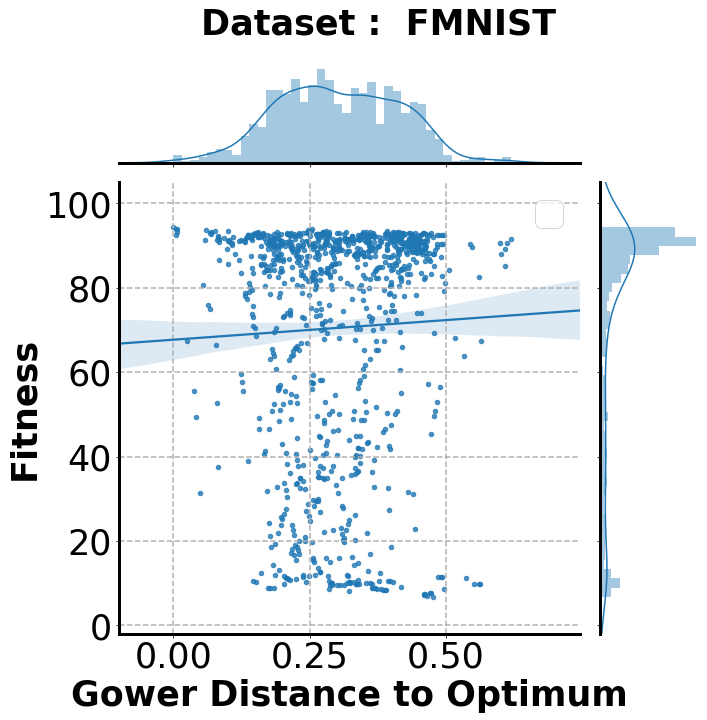

In [13]:
import seaborn as sns
import gower
import matplotlib
#matplotlib.style.use('fivethirtyeight')

prefix_filename = "../data/openml-pimp/DS2019/results_fla/"
##
target_feature = measures[0]
n_sample = 1000
C_discr = 40

figsize = (C_discr * 1.2, 4.25)

# Looping over the HPO problems
for dataset_id in list_dataset_ids:
    
    wrn = df.loc[df['dataset']==dataset_id]
    
    print(dataset_id, wrn.shape)
    

    

    ## Identifying the best
    best_wrn = wrn.loc[wrn[target_feature] == max(wrn[target_feature])]

    #Sampling solutions    
    wrn_sample = wrn.sample(n=n_sample)
    concat_wrn_best_s = pd.concat([best_wrn, wrn_sample])

    ## Pairwise distance to Opt

    gower_mat= gower.gower_matrix(concat_wrn_best_s[hyperparameter_features])

    xs_dist = gower_mat[0]
    ys_fitness = concat_wrn_best_s[target_feature].to_numpy()

    assert len(xs_dist) == len(ys_fitness)

    xys = [(x, y) for (x, y) in zip(xs_dist, ys_fitness)]

    ### Sorting per dist to opt
    xys_sorted = sorted(xys, key=lambda tuple: tuple[0])

    plt.rcParams.update({'font.size': 35, 'axes.linewidth':3})
    
    #rcParams['axes.linewidth'] = 0.
    local_font_size = 35
    local_title_size = local_font_size
    plt.figure(figsize=(2.75,2.75))
    #sns.set(font_scale = 2)
    sns.jointplot([x[0] for x in xys_sorted] ,[x[1] for x in xys_sorted],
                  kind="reg",
                  height=10,
                  ratio=4,
                  marginal_kws=dict(bins=C_discr), scatter_kws={'s': 20})
    #plt.title('FDC plot - DS2019 / CNN /' + dataset_id,  fontsize=local_title_size, fontweight='bold')
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Dataset :  ' + dataset_id.upper(),  fontsize=local_title_size, fontweight='bold')
    plt.xlabel('Gower Distance to Optimum',  fontsize=local_font_size, fontweight='bold')
    plt.ylabel('Fitness', fontsize=local_font_size, fontweight='bold') # (' + target_feature + ')')
    #plt.grid(True)
    plt.grid(True, ls="--", lw=1.5, alpha=1.)
    plt.ylim(-2,105)
    #max_y_axis = max([x[] for x in xys_sorted]) + 0.1
    plt.xlim(left=-0.1)
    plt.legend()
    plt.savefig(prefix_filename + "fdc/fdc_" + dataset_id + ".png", bbox_inches = 'tight')
    
    
    fitness_all = [x[1] for x in xys_sorted]
    distance_all = [x[0] for x in xys_sorted]
    
    max_fit = max(fitness_all)
    threshold_fitness = max_fit / C_discr
    print(max_fit, threshold_fitness)
    
    max_dist = max(distance_all)
    threshold_gower = max_dist / C_discr
    print(max_dist, threshold_gower)
    
    
    ndeg_filename = prefix_filename + "neutrality/neutrality_deg_" + dataset_id + ".png"
    avg_nei_filename = prefix_filename + "neighborhood_fitness/avg_neigh_" + dataset_id + ".png"
    
    Ndeg_per_fitness, avg_fitness_Nei_per_fitness = assess_neighborhood(concat_wrn_best_s, 
                                                                    hyperparameter_features=hyperparameter_features, 
                                                                    fitness_metric=target_feature, 
                                                                    threshold_gower=threshold_gower, 
                                                                    threshold_fitness=threshold_fitness)

    plot_avg_neighborhood_fitness(avg_fitness_Nei_per_fitness, fitness_metric=target_feature, 
                       dataset_id=dataset_id, threshold_fitness=threshold_fitness, 
                       figsize=figsize, save_filename=avg_nei_filename) 
    
    plot_neutrality_degree(Ndeg_per_fitness, fitness_metric=target_feature, 
                       dataset_id=dataset_id, threshold_fitness=threshold_fitness, 
                       figsize=figsize, save_filename=ndeg_filename)